In [66]:
import tweepy 
import csv
import json
import re
from tweepy import OAuthHandler
import datetime
import time

#load twitter credentials from file 
consumer_key = 'kAULSmYrpuA7idFEYJmmVJqsZ'
consumer_secret = 'NGyXI8OEKbNkpCfL1jrSLWy2pCSsZPz1nCE3P6qFXzh2Nqsog2'
access_token = '466693964-vVTSjjGghi6K4qnlReqfrUq0uPj4o4Jw8UYVGTNz'
access_token_secret = '7gweeKfNBJzDj4hqy4OmDqufBjcI7pP2KMpb5SWYqUxu0'

# Set up OAuth and integrate with API
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [67]:
def datetime_from_utc_to_local(utc_datetime):
    now_timestamp = time.time()
    offset = datetime.datetime.fromtimestamp(now_timestamp) - datetime.datetime.utcfromtimestamp(now_timestamp)
    return utc_datetime + offset

In [68]:
#function to clean up the text of tweet 
def clean_tweet(tweet): 
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) (\w+:\/\/\S+)", " ", tweet).split())

In [69]:
#simpler function to get tweets, doesnt work? 
def get_tweets_simple(query, max_tweets):
    searched_tweets = [status for status in tweepy.Cursor(api.search, q=query).items(max_tweets)]
    tweets = []
    twees_date = []
    for tweet in searched_tweets:
        # empty dictionary to store required params of a tweet 
        parsed_tweet = {}
        # saving text of tweet 
        #parsed_tweet['text'] = clean_tweet(tweet.text)
        created_date_local = datetime_from_utc_to_local(tweet.created_at)
       # tweets = created_date_local
        parsed_tweet['date'] = created_date_local
        #print(created_date_local)
        #print(parsed_tweet.created_at )
        tweets.append(parsed_tweet)
    return tweets

In [70]:
#more complicated function to download tweets for given query
def get_tweets(query, max_tweets):
    searched_tweets = []
    last_id = -1
    while len(searched_tweets) < max_tweets:
        count = max_tweets - len(searched_tweets)
        try:
            new_tweets = api.search(q = query, count = count, max_id = str(last_id - 1))
            if not new_tweets:
                break
            searched_tweets.extend(new_tweets)
            last_id = new_tweets[-1].id
        except tweepy.TweepError as e:
        # depending on TweepError.code, one may want to retry or wait
        # to keep things simple, we will give up on an error
            break
            
    tweets = []
    for tweet in searched_tweets:
        # empty dictionary to store required params of a tweet 
        parsed_tweet = {}
        # saving text of tweet 
        parsed_tweet['text'] = clean_tweet(tweet.text)
        
        tweets.append(parsed_tweet)
            
    return tweets

In [71]:
#return all tweets from given screenname
def get_tweets_user(screen_name, max_tweets, startDate, endDate):
    searched_tweets = []
    last_id = -1
    while len(searched_tweets) < max_tweets:
        count = max_tweets - len(searched_tweets)
        try:
            #new_tweets = api.user_timeline(id = screenname, count = count, max_id = str(last_id - 1))
            new_tweets = api.user_timeline(screen_name = screen_name, count = max_tweets, include_rts = True)
            if not new_tweets:
                break
            searched_tweets.extend(new_tweets)
            last_id = new_tweets[-1].id
        except tweepy.TweepError as e:
        # depending on TweepError.code, one may want to retry or wait
        # to keep things simple, we will give up on an error
            break
            
    tweets = []

    for tweet in searched_tweets:
        if datetime_from_utc_to_local(tweet.created_at) < endDate and datetime_from_utc_to_local(tweet.created_at) > startDate:   
            # empty dictionary to store required params of a tweet 
            # saving text of tweet 
            parsed_tweet = {}

            parsed_tweet['text'] = clean_tweet(tweet.text)
            parsed_tweet['date'] = datetime_from_utc_to_local(tweet.created_at)
            tweets.append(parsed_tweet)
            
    return tweets

In [72]:
#return all tweets from given screenname between given dates
def get_tweets_user_dates(username, startDate, endDate):
    tweets = []
    tmpTweets = api.user_timeline(username)
    for tweet in tmpTweets:
        if tweet.created_at < endDate and tweet.created_at > startDate:
            tweets.append(tweet)

    while (tmpTweets[-1].created_at > startDate):#Avoids repeating tweet
        #print("Last Tweet @", tmpTweets[-1].created_at)
        tmpTweets = api.user_timeline(username, max_id = tmpTweets[-1].id)
        for tweet in tmpTweets:
            if datetime_from_utc_to_local(tweet.created_at) < endDate and datetime_from_utc_to_local(tweet.created_at) > startDate:
                parsed_tweet = {}
                parsed_tweet['text'] = clean_tweet(tweet.text)
                parsed_tweet['date'] = datetime_from_utc_to_local(tweet.created_at)
                tweets.append(parsed_tweet)
    return tweets

In [73]:
start_date = datetime.datetime(2018,1,10) # Beginning of period 
end_date = datetime.datetime(2018,6,16) # End of period
baracks_tweets = get_tweets_user_dates('elonmusk', start_date, end_date)


IndexError: list index out of range

In [55]:
len(baracks_tweets)
#baracks_tweets

129

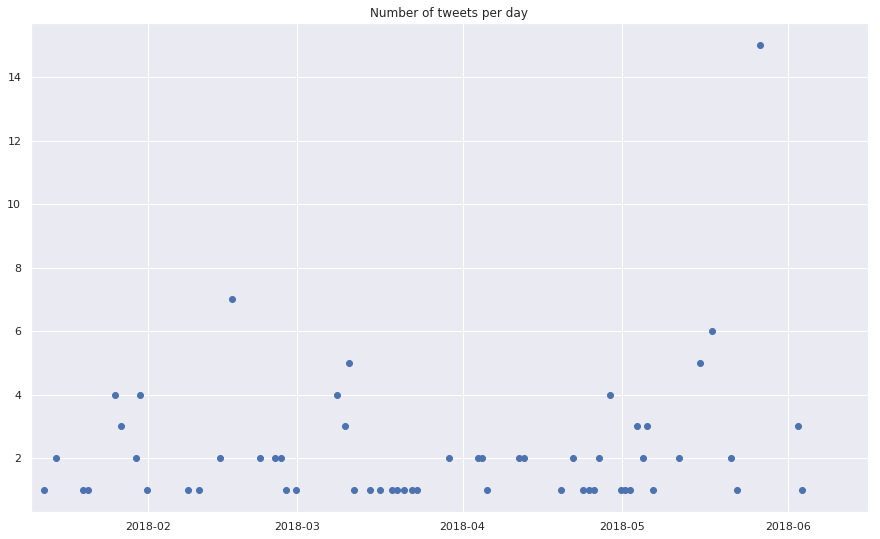

In [56]:
import numpy as np
tweet_date = []
tweet_count = []#np.array(x)
count=0

for i in range(0,len(baracks_tweets)):
    if i==0: continue
    #print(baracks_tweets[i]['date'].day)
    if baracks_tweets[i]['date'].day==baracks_tweets[i-1]['date'].day:
        count+=1    #else:
    else:
        count+=1
        tweet_date.append(baracks_tweets[i]['date'])
        tweet_count.append(count)
        count=0

    #minute = tweet['date'].minute
    #tweet_count+=1
#print(count)   
#print(tweet_count,tweet_date)
#tweet_date
plt.scatter(tweet_date,tweet_count);
plt.title("Number of tweets per day")
plt.xlim(start_date,end_date);

Populating the interactive namespace from numpy and matplotlib


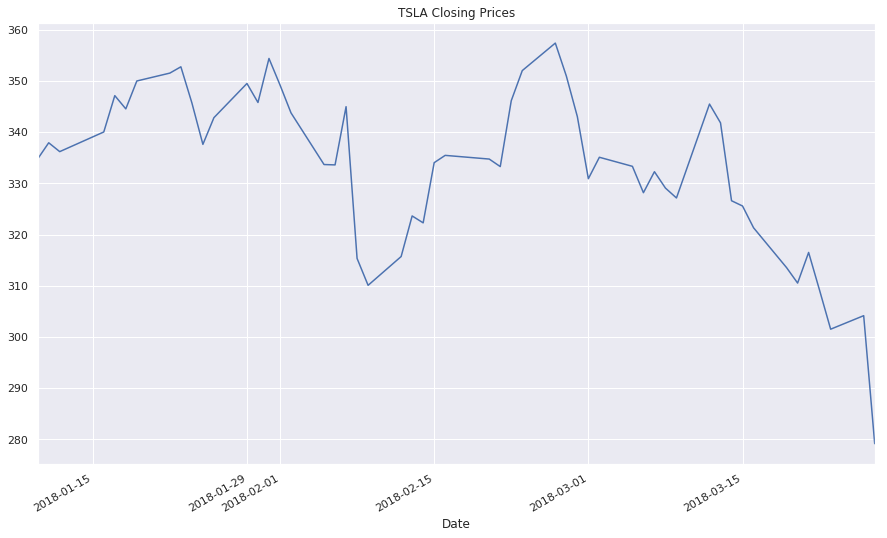

In [57]:
import pandas as pd
import quandl #quandl is not installed by default. You'll need to install it and get an account.
import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
%pylab inline
quandl.ApiConfig.api_key = "cHs3hSC-ys83Msb8qXyh"#This is Jorge's key, get yourself a new one.

#start_date = datetime.datetime(2015,1,1) # Beginning of period 
#end_date = datetime.datetime(2015,2,1) # End of period 
stock = "TSLA" # some stock label we are interested in
tesla = quandl.get("WIKI/" + stock, start_date=start_date, end_date=end_date) #download data with quandl
pylab.rcParams['figure.figsize'] = (15, 9)
plt.title(stock + " Closing Prices")
tesla["Close"].plot() # plot daily closing prices 
plt.show()